In [4]:
import os
os.chdir('/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification')

In [5]:
import torch
import matplotlib.pyplot as plt

import numpy as np
import rasterio
from src.CNN.CNN_Model import CropTypeClassifier
from shapely.geometry import Point, Polygon
import h5py



In [6]:
label_map = {
    1: "Garlic", 2: "Winter_Oat", 3: "Spring_Oat", 4: "Winter_Durum_Wheat", 5: "Spring_Durum_Wheat",
    6: "Meadow", 7: "Buffer_Strip", 8: "Winter_Wheat", 9: "Beet", 10: "Spring_Wheat",
    11: "Carrot", 12: "Cucumber_Gherkin", 13: "Buckwheat", 14: "Sorghum", 15: "Winter_Rye",
    16: "Fodder", 17: "Rapeseed", 18: "Spelt", 19: "Spinach", 20: "Annual_Vegetable_Fruit",
    21: "Perennial_Vegetable_Fruit", 23: "Hops", 24: "Lavender_Lavandin", 25: "Lettuce_Batavia_Oak_Leaf",
    26: "Grain_Lentil", 27: "Spring_Oil_Flax", 28: "Alfalfa", 29: "Forage_Legume_Cereal_Oilseed_Mix",
    30: "Maize", 31: "Forage_Legume_Mix", 32: "Melon", 33: "Early_Proteaginous_Cereal_Mix",
    34: "Onion_Shallot", 35: "Olive", 36: "Barley", 37: "Chickpea", 38: "Winter_Pea",
    39: "Pumpkin_Red_Kuri", 40: "Early_Spring_Pea", 41: "Potato", 42: "Williams_Pear",
    43: "Vineyard", 44: "Sainfoin", 45: "Soybean", 46: "Clover", 47: "Sunflower",
    48: "Winter_Triticale", 49: "Orchard", 0: "Not a field crops", 22: "Other"
}


In [37]:

model_path='checkpoints/best_model_cnn.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(model_path, device):
    # Instancier ton modèle (adapte le constructeur à ta classe)
    model = CropTypeClassifier(num_classes=51,kernel_size=5)  
    # Charger les poids
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # Envoyer le modèle sur le device (CPU ou GPU)
    model.to(device)
    
    return model

model = load_model(model_path, device)

In [38]:
import h5py
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with h5py.File("manual_jobs/dataset_test.h5", "r+") as f:
    # Charger les données
    X = torch.tensor(f["data"][:])               # shape [N, T, C, H, W] ou [N, C, T, H, W] ? Vérifie format exact !
    Y = torch.tensor(f["labels"][:]).long()      # shape [N, H, W]
    zones = f["zones"][:]                         # bytes ou string
    coords = f["coords"][:]                       # shape [N, 2]



    # Dataset et DataLoader
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    pred_list = []

    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(dataloader)):
            x = x.to(device)
            output = model(x)  # Sortie shape: [1, num_classes, H, W]
            pred_patch = output.argmax(dim=1).squeeze(0).cpu().numpy()  # [H, W]
            pred_list.append(pred_patch)

    # Convertir en numpy array
    preds_np = np.stack(pred_list, axis=0)  # [N_filtered, H, W]

    # Supprimer dataset predictions s'il existe déjà
    if "predictions" in f:
        del f["predictions"]

    # Créer nouveau dataset predictions
    f.create_dataset("predictions", data=preds_np, dtype='int64')

100%|██████████| 18704/18704 [15:01<00:00, 20.75it/s]


In [86]:
# Fonction pour créer la mosaïque spatiale
def create_spatial_mosaic_from_geo_coords(patches, geo_coords, patch_size, transform):
    pixel_coords = [rasterio.transform.rowcol(transform, lon, lat) for lon, lat in geo_coords]
    rows = [r for r, c in pixel_coords]
    cols = [c for r, c in pixel_coords]

    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)

    height = max_row - min_row + patch_size[0]
    width = max_col - min_col + patch_size[1]

    mosaic = np.full((height, width), -1, dtype=patches[0].dtype)

    for patch, (row, col) in zip(patches, pixel_coords):
        row_offset = row - min_row
        col_offset = col - min_col
        mosaic[row_offset:row_offset+patch_size[0], col_offset:col_offset+patch_size[1]] = patch

    return mosaic

In [89]:
def plot_with_label_colorbar(mosaic, title,cmap,norm, labels_text,n):
    # classes uniques présentes (exclure -1)
    unique_classes = np.unique(mosaic.compressed() if np.ma.isMaskedArray(mosaic) else mosaic)
    unique_classes = unique_classes[unique_classes != -1]

    plt.figure(figsize=(12, 12))
    plt.title(title)
    im = plt.imshow(mosaic, cmap=cmap, norm=norm)

    # Colorbar ticks uniquement sur les classes présentes
    cbar = plt.colorbar(im, ticks=range(n))

    # Afficher seulement les labels des classes présentes
    cbar.ax.set_yticklabels([labels_text[i] for i in unique_classes])
    plt.show()

In [ ]:
label_map = {
    1: "Garlic", 2: "Winter_Oat", 3: "Spring_Oat", 4: "Winter_Durum_Wheat", 5: "Spring_Durum_Wheat",
    6: "Meadow", 7: "Buffer_Strip", 8: "Winter_Wheat", 9: "Beet", 10: "Spring_Wheat",
    11: "Carrot", 12: "Cucumber_Gherkin", 13: "Buckwheat", 14: "Sorghum", 15: "Winter_Rye",
    16: "Fodder", 17: "Rapeseed", 18: "Spelt", 19: "Spinach", 20: "Annual_Vegetable_Fruit",
    21: "Perennial_Vegetable_Fruit", 23: "Hops", 24: "Lavender_Lavandin", 25: "Lettuce_Batavia_Oak_Leaf",
    26: "Grain_Lentil", 27: "Spring_Oil_Flax", 28: "Alfalfa", 29: "Forage_Legume_Cereal_Oilseed_Mix",
    30: "Maize", 31: "Forage_Legume_Mix", 32: "Melon", 33: "Early_Proteaginous_Cereal_Mix",
    34: "Onion_Shallot", 35: "Olive", 36: "Barley", 37: "Chickpea", 38: "Winter_Pea",
    39: "Pumpkin_Red_Kuri", 40: "Early_Spring_Pea", 41: "Potato", 42: "Williams_Pear",
    43: "Vineyard", 44: "Sainfoin", 45: "Soybean", 46: "Clover", 47: "Sunflower",
    48: "Winter_Triticale", 49: "Orchard", 0: "Not a field crops", 22: "Other"
}

In [101]:
h5_path = "manual_jobs/dataset_test.h5"
patch_size = (24, 24)  # ou la taille de tes patchs
# Charger la transformée affine (exemple)
with rasterio.open('/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification/data/Tif/zone1/labels_raster_masked.tif') as src:
    transform = src.transform
target_zone = "zone1"

with h5py.File(h5_path, "r") as f:
    preds = f["predictions"][:]     # [N, H, W]
    labels = f["labels"][:]         # [N, H, W]
    coords = f["coords"][:]         # [N, 2] format (lon, lat)
    zones = f["zones"][:]           # [N] zone associée à chaque patch

# === Convertir zones en chaînes de caractères ===
zones = [z.decode('utf-8') if isinstance(z, bytes) else str(z) for z in zones]

# === Filtrer les indices de la zone ciblée ===
selected_indices = [i for i, z in enumerate(zones) if z == target_zone]

# === Appliquer la sélection ===
pred_patches = [preds[i] for i in selected_indices]
gt_patches = [labels[i] for i in selected_indices]
geo_coords = [tuple(coords[i]) for i in selected_indices]


# === Créer les mosaïques spatiales ===
mosaic_pred = create_spatial_mosaic_from_geo_coords(pred_patches, geo_coords, patch_size, transform)
mosaic_gt = create_spatial_mosaic_from_geo_coords(gt_patches, geo_coords, patch_size, transform)

In [106]:
H, W = mosaic_pred.shape[:2]
zoom_factor = 1

zoom_h = H // zoom_factor
zoom_w = W // zoom_factor

# Exemple : zoom sur le coin supérieur droit
zoomed_gt = mosaic_gt[0:zoom_h, W - zoom_w:W]
zoomed_preds = mosaic_pred[0:zoom_h, W - zoom_w:W]

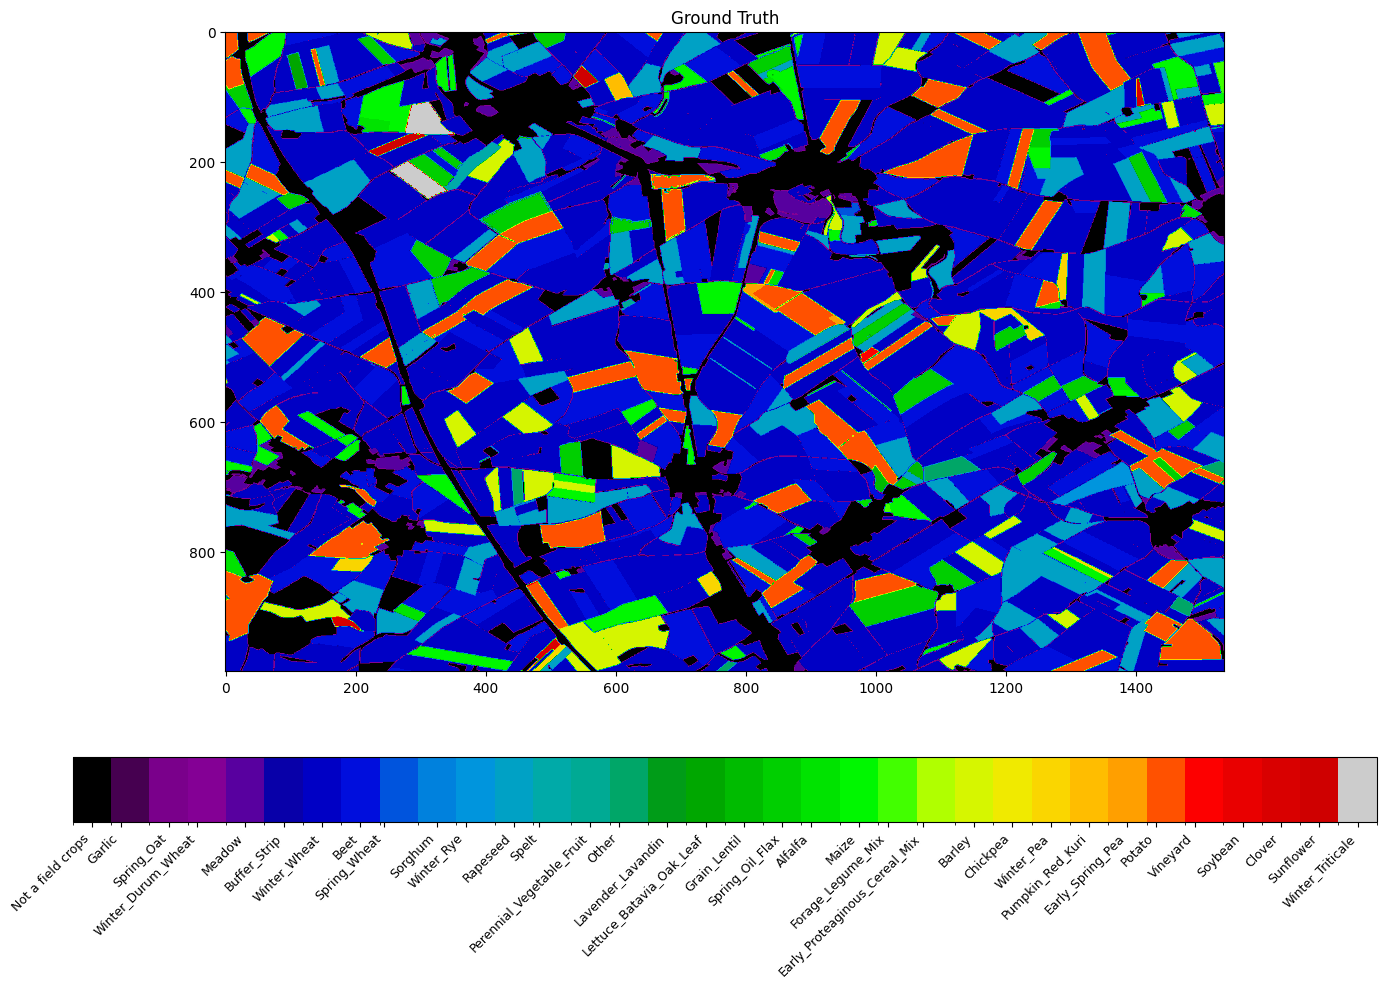

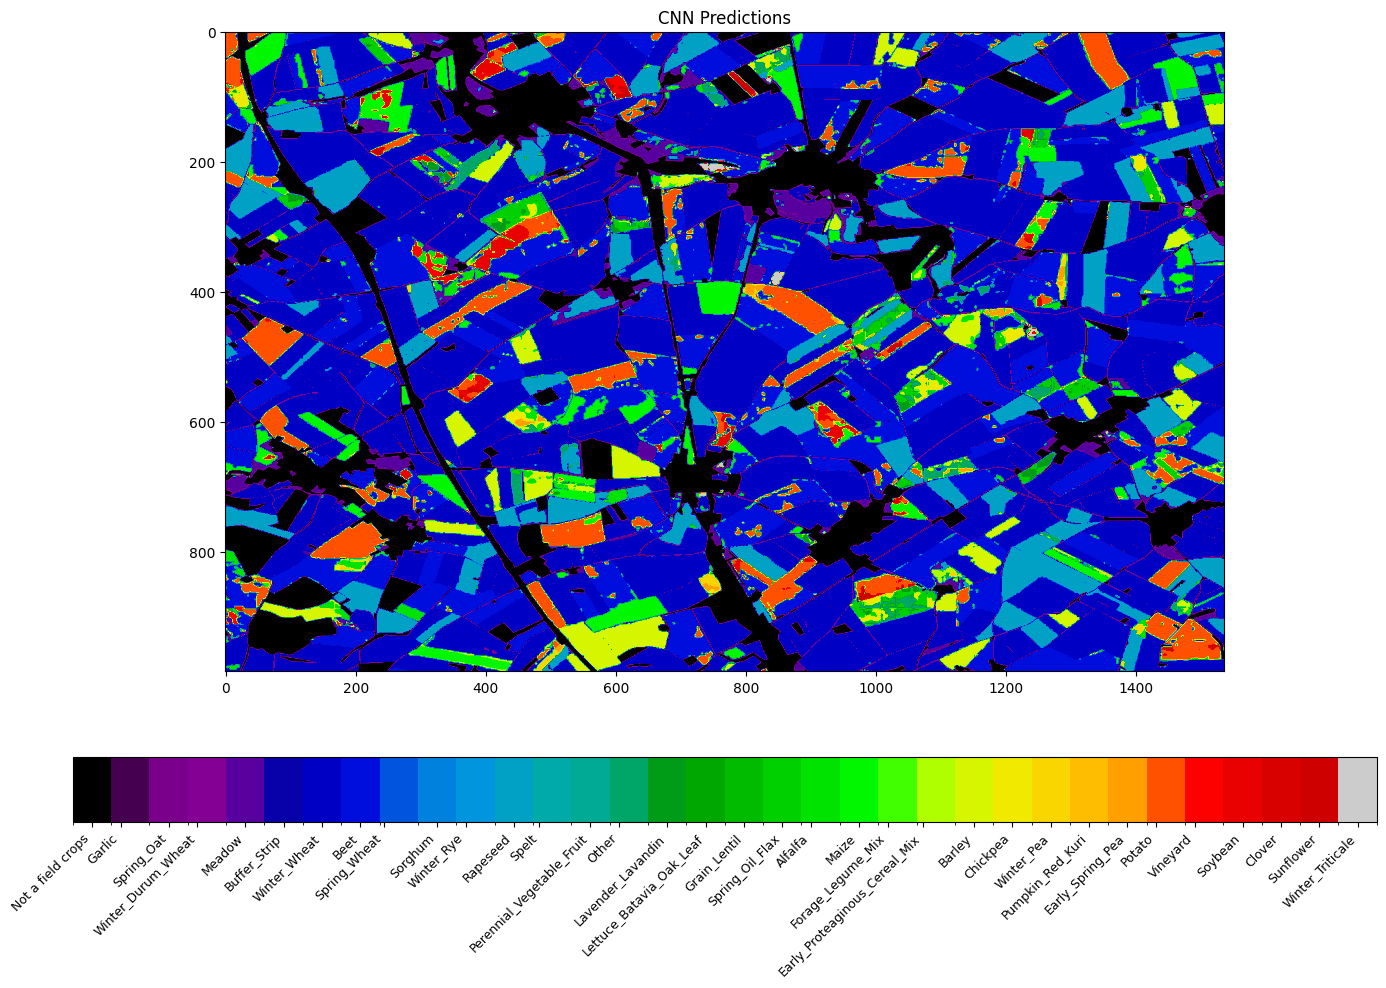

In [107]:
# Étape 1 — Extraire les classes réellement présentes dans chaque mosaïque
def get_present_classes(mosaic):
    unique = np.unique(mosaic.compressed() if np.ma.isMaskedArray(mosaic) else mosaic)
    return unique[unique != -1]

classes_gt = get_present_classes(zoomed_gt)
classes_pred = get_present_classes(zoomed_preds)

# Union des classes pour s'assurer que colormap couvre les deux
all_present_classes = np.unique(np.concatenate([classes_gt, classes_pred]))

# Étape 2 — Créer un cmap spécifique aux classes présentes
cmap = plt.get_cmap('nipy_spectral', len(all_present_classes))
norm = mcolors.BoundaryNorm(boundaries=np.array(all_present_classes) - 0.5, ncolors=len(all_present_classes))


labels_text = [label_map.get(i, f"Class {i}") for i in all_present_classes]


def plot_with_label_colorbar(mosaic, title, cmap, norm, class_ids, labels_text):
    plt.figure(figsize=(14, 10))
    plt.title(title)
    im = plt.imshow(mosaic, cmap=cmap, norm=norm)

    # Colorbar horizontale en bas
    cbar = plt.colorbar(im, ticks=class_ids, orientation='horizontal', pad=0.1)
    cbar.ax.set_xticklabels(labels_text, rotation=45, ha='right', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_with_label_colorbar(zoomed_gt, "Ground Truth", cmap, norm, all_present_classes, labels_text)
plot_with_label_colorbar(zoomed_preds, "CNN Predictions", cmap, norm, all_present_classes, labels_text)


In [108]:
import plotly.express as px
import numpy as np
import pandas as pd

def plot_interactive_mosaic(mosaic, title, class_ids, labels_text):
    """
    Affiche une mosaïque interactive avec hover montrant le nom de la classe.

    Args:
        mosaic (np.ndarray): [H, W] array avec les IDs des classes.
        title (str): Titre du graphique.
        class_ids (List[int]): IDs des classes utilisées.
        labels_text (List[str]): Noms des classes correspondants aux IDs.
    """
    # Créer une DataFrame pour Plotly
    df = pd.DataFrame(mosaic)
    df.index.name = "Y"
    df.columns.name = "X"

    df_melted = df.reset_index().melt(id_vars="Y", var_name="X", value_name="ClassID")
    
    # Mapper ClassID → label
    label_map = {cid: label for cid, label in zip(class_ids, labels_text)}
    df_melted["ClassName"] = df_melted["ClassID"].map(label_map).fillna("Unknown")

    # Plot interactif
    fig = px.imshow(
        mosaic,
        color_continuous_scale="viridis",
        aspect="equal",
        title=title,
        labels={"color": "Class ID"},
    )

    # Ajouter le texte au survol
    hover_text = df_melted["ClassName"].values.reshape(mosaic.shape)
    fig.update_traces(
        hovertemplate="Class: %{customdata}<extra></extra>",
        customdata=hover_text
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="Class ID",
            tickvals=class_ids,
            ticktext=labels_text,
        )
    )

    fig.show()

In [110]:
plot_interactive_mosaic(
    mosaic=mosaic_pred,
    title="Predicted Mosaic (Interactive)",
    class_ids=list(label_map.keys()),
    labels_text=list(label_map.values())
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [51]:
with h5py.File("manual_jobs/dataset_test.h5", "r") as f:
    # Ground truth labels (N, H, W)
    gt_array = f["labels"][:]
    pred_array = f["predictions"][:]


# Aplatir toutes les prédictions et ground truth en 1D pour la matrice de confusion
y_true = gt_array.flatten()
y_pred = pred_array.flatten()

y_true = y_true.astype(np.int64)
y_pred = y_pred.astype(np.int64)

In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
import pandas as pd
num_classes = len(label_map)

# Calculer les counts de prédiction et ground truth par classe
pred_counts = np.bincount(y_pred, minlength=num_classes)
gt_counts = np.bincount(y_true, minlength=num_classes)

# Calculer les metrics par classe (ignorer zéro division)
precision_per_class = precision_score(y_true, y_pred, labels=list(range(num_classes)), average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, labels=list(range(num_classes)), average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, labels=list(range(num_classes)), average=None, zero_division=0)

# Préparer le dataframe
df_metrics = pd.DataFrame({
    "Class": [label_map[i] for i in range(num_classes)],
    "Pred_Count": pred_counts,
    "GT_Count": gt_counts,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1": f1_per_class
})

# Optionnel : trier par GT_Count décroissant
df_metrics = df_metrics.sort_values(by="GT_Count", ascending=False).reset_index(drop=True)
df_metrics = df_metrics.round(2)
print(df_metrics)

                               Class  Pred_Count  GT_Count  Precision  Recall  \
0                  Not a field crops     2822760   2821830       1.00    1.00   
1                       Winter_Wheat     2421938   2268343       0.89    0.95   
2                              Maize     1247592   1251855       0.92    0.92   
3                             Meadow     1197183    859652       0.65    0.91   
4                           Vineyard      755401    694536       0.88    0.96   
5                           Rapeseed      522462    554196       0.97    0.91   
6                             Barley      451592    486399       0.86    0.80   
7                          Sunflower      344674    406918       0.90    0.76   
8                               Beet      270759    269068       0.88    0.88   
9                            Alfalfa      191561    187163       0.50    0.51   
10                Winter_Durum_Wheat       62691    173329       0.74    0.27   
11                          

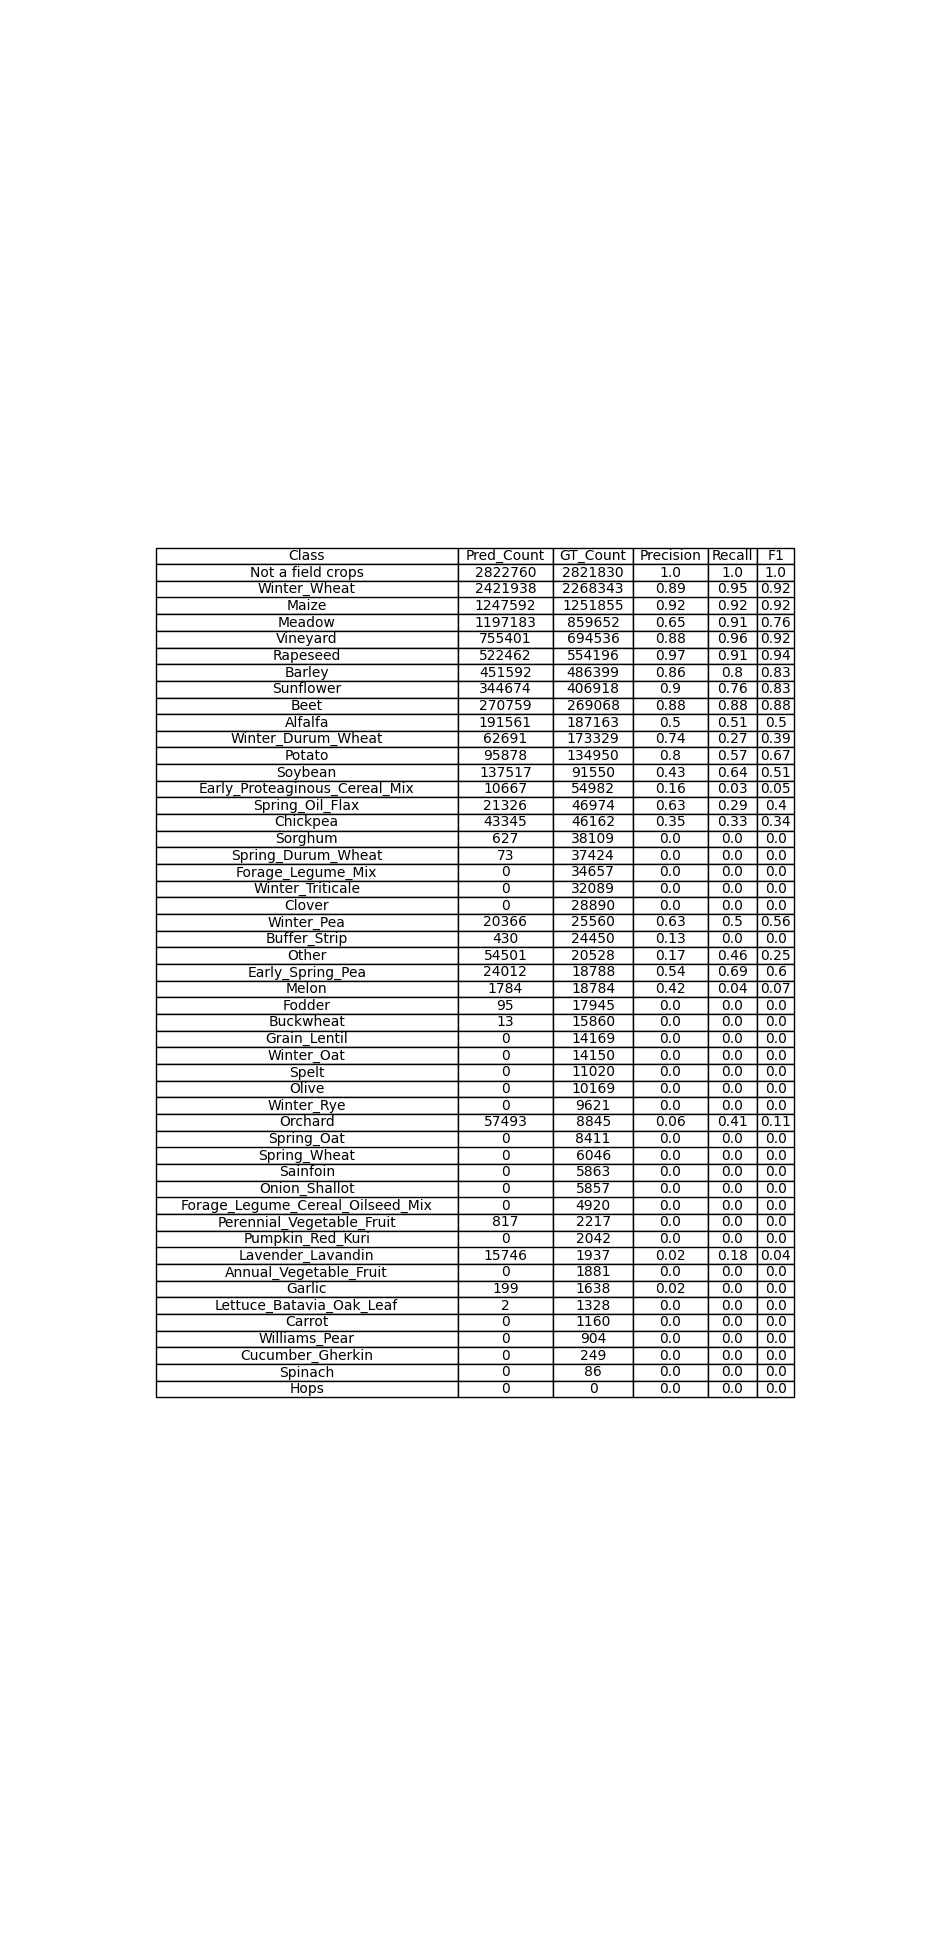

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, len(df_metrics)*0.5))  # ajuste la taille selon le nombre de lignes
ax.axis('off')  # cacher les axes

# Affiche la table
table = ax.table(
    cellText=df_metrics.values,
    colLabels=df_metrics.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df_metrics.columns))))

plt.show()

/var/folders/5y/cg3f72r56ndb2p52h64tts3m0000gn/T/ipykernel_45934/1626341482.py:16: RuntimeWarning: invalid value encountered in divide
  conf_norm = conf_mat.astype('float') / conf_mat.sum(axis=1, keepdims=True)


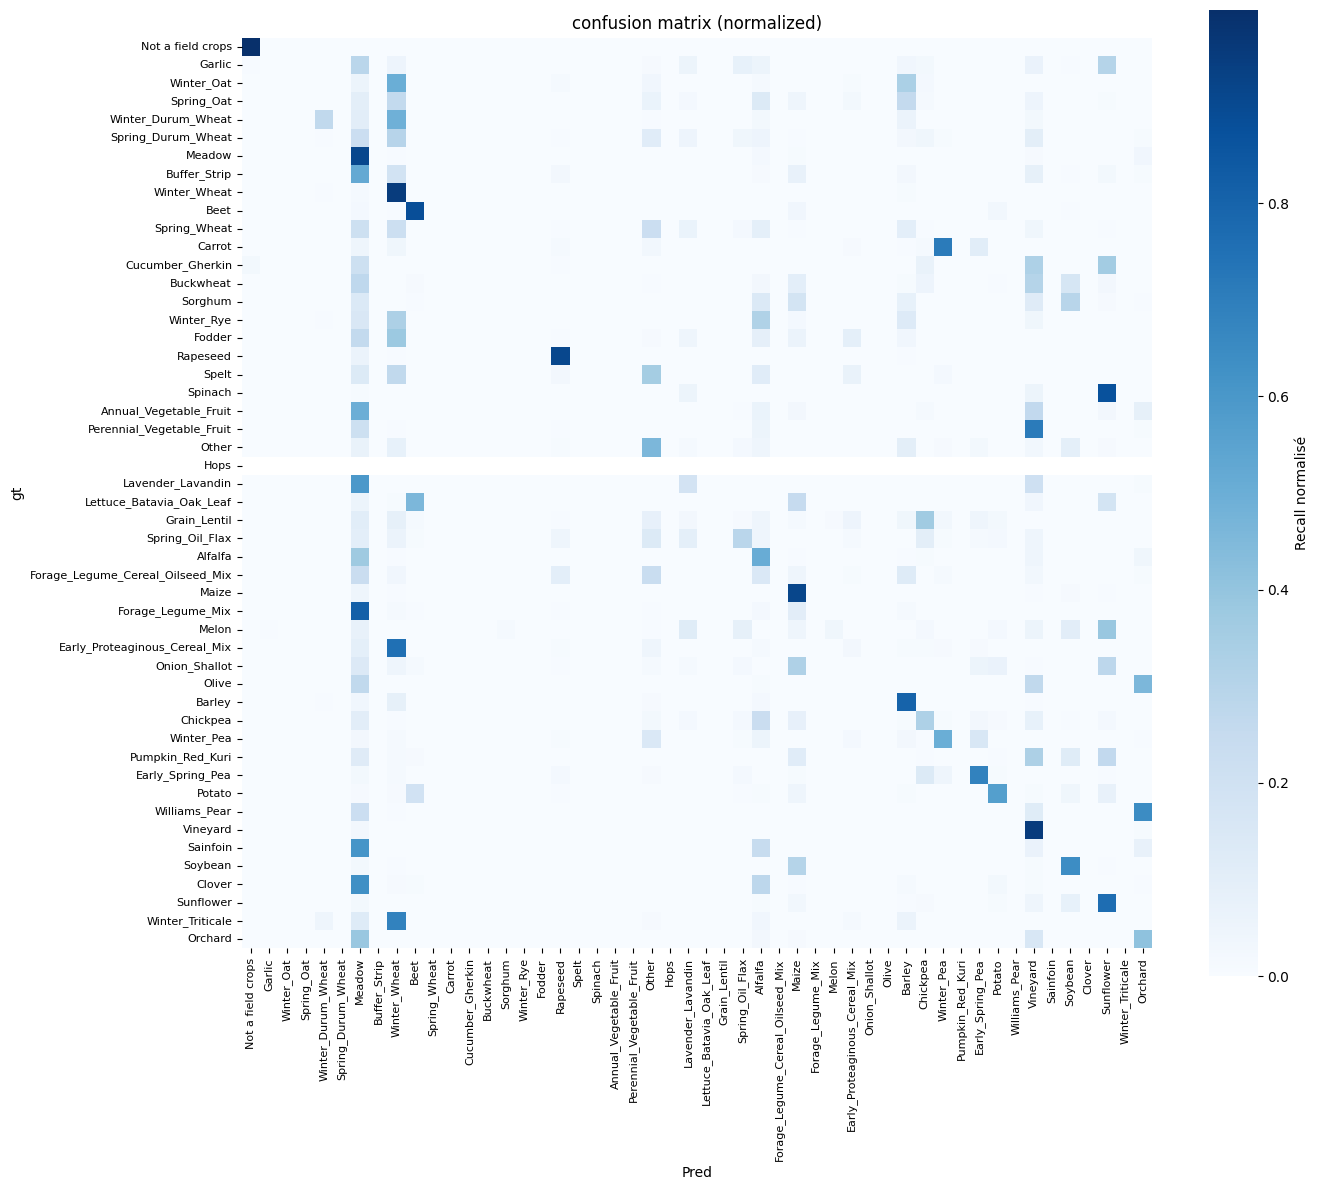

In [61]:
num_classes = max(label_map.keys()) + 1
class_names = [label_map.get(i, f"Class {i}") for i in range(num_classes)]

# === Chargement HDF5 ===
with h5py.File("manual_jobs/dataset_test.h5", "r") as f:
    y_true = f["labels"][:].flatten().astype(np.int64)
    y_pred = f["predictions"][:].flatten().astype(np.int64)

# === Masque pour exclure les classes ignorées ===
mask = (y_true != 255)
y_true = y_true[mask]
y_pred = y_pred[mask]

# === Matrice de confusion normalisée par ligne (Recall) ===
conf_mat = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
conf_norm = conf_mat.astype('float') / conf_mat.sum(axis=1, keepdims=True)

# === Affichage avec noms humains ===
plt.figure(figsize=(14, 12))
sns.heatmap(conf_norm, cmap='Blues', square=True, 
            xticklabels=class_names, yticklabels=class_names, 
            cbar_kws={'label': 'Recall normalisé'})
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.xlabel("Pred")
plt.ylabel("gt")
plt.title("confusion matrix (normalized)")
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import statsmodels.api as sm

# Exemple de données
df = pd.DataFrame({
    'y': [1, 2, 3, 4, 5],
    'x1': [2, 1, 3, 5, 4],
    'x2': [5, 3, 6, 9, 8]
})

# On ajoute une constante pour l'intercept (comme R le fait automatiquement)
X = sm.add_constant(df[['x1', 'x2']])
y = df['y']

# Modèle de régression linéaire
model = sm.OLS(y, X).fit()

# Résumé du modèle (comme summary(lm(...)) en R)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     1.778
Date:                Mon, 21 Jul 2025   Prob (F-statistic):              0.360
Time:                        11:46:41   Log-Likelihood:                -6.2734
No. Observations:                   5   AIC:                             18.55
Df Residuals:                       2   BIC:                             17.38
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6000      4.395      0.137      0.9

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
